In [1]:
import pandas as pd
import numpy as np
import keras
import os
from src.constants import Constants2, params_blog_2, hyperparameter_space
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_poisson_deviance
from typing import *
import time
from src.utils import *
from collections import defaultdict
from pprint import pprint
import random
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# https://github.com/RonRichman/AI_in_Actuarial_Science/blob/master/NL%20Pricing/Keras%20-%20NL%20Pricing%20-%20NN_embed_transfer.R#L177
# https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/
# https://towardsdatascience.com/interpretability-of-deep-learning-models-9f52e54d72ab
# https://towardsdatascience.com/feed-forward-neural-networks-how-to-successfully-build-them-in-python-74503409d99a

In [3]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format','{:,.4f}'.format)

In [4]:
RANDOM_STATE = params_blog_2.get(Constants2.RANDOM_STATE)
TEST_SIZE = params_blog_2.get(Constants2.TEST_SIZE)
VAL_SIZE = params_blog_2.get(Constants2.VAL_SIZE_FROM_TRAIN_SIZE)

In [5]:
PATH_TO_DATA = params_blog_2.get(Constants2.PATH_TO_DATA)
nb_claims_name, claim_amount_name = params_blog_2.get(Constants2.NB_CLAIMS), params_blog_2.get(Constants2.CLAIM_AMOUNT)
claim_frequency_name = params_blog_2.get(Constants2.CLAIM_FREQUENCY)
exposure_name = params_blog_2.get(Constants2.EXPOSURE_NAME)

In [6]:
df_freq = pd.read_pickle(os.path.join(PATH_TO_DATA, params_blog_2.get(Constants2.DATASET_FREQ_NAME)))
df_sev = pd.read_pickle(os.path.join(PATH_TO_DATA, params_blog_2.get(Constants2.DATASET_SEV_NAME)))

In [7]:
df_freq.head(2).transpose()

,0,1
ClaimNb,0.0000,0.0000
Exposure,0.0900,0.8400
ClaimAmount,0.0000,0.0000
claim_frequency,0.0000,0.0000
power_d,0.0000,0.0000
power_e,0.0000,0.0000
power_f,0.0000,0.0000
power_g,1.0000,1.0000
power_h,0.0000,0.0000
power_i,0.0000,0.0000


In [8]:
nb_claims, claim_amount = df_freq[nb_claims_name], df_freq[claim_amount_name]
X = df_freq.drop(columns=[claim_amount_name, claim_frequency_name])

In [9]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, nb_claims, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=X[nb_claims_name])


In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, 
                                                    test_size=VAL_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                   stratify=x_train_val[nb_claims_name])

In [11]:
exp_train, exp_val, exp_test = x_train[exposure_name], x_val[exposure_name], x_test[exposure_name]

In [12]:
x_train = x_train.drop(columns=[nb_claims_name])
x_val = x_val.drop(columns=[nb_claims_name])
x_test = x_test.drop(columns=[nb_claims_name])

In [13]:
DATASET_TRAIN = pd.concat([x_train, y_train], axis=1)

In [14]:
formula_freq = f'{nb_claims_name} ~ ' + ' + '.join( [c for c in x_train.columns if c!= exposure_name])
formula_freq

'ClaimNb ~ power_d + power_e + power_f + power_g + power_h + power_i + power_j + power_k + power_l + power_n + power_o + brand_fiat + brand_mercedes_chrysler_bmw + brand_opel_generalmotors_ford + brand_renault_nissan_citroen + brand_volkswagen_audi_skoda_seat + brand_other + gas_regular + region_aquitaine + region_basse_normandie + region_bretagne + region_centre + region_ile_de_france + region_limousin + region_nord_pas_de_calais + region_pays_de_la_loire + region_poitou_charentes + driverage_bin_18_to_32 + driverage_bin_32_to_40 + driverage_bin_40_to_48 + driverage_bin_48_to_57 + carage_bin_2_to_5 + carage_bin_5_to_9 + carage_bin_9_to_13 + carage_bin_13_to_100 + density_bin_51_to_150 + density_bin_150_to_555 + density_bin_555_to_2404 + density_bin_2404_27000'

In [15]:
freq_glm = smf.glm(formula=formula_freq,
                   data=DATASET_TRAIN, 
                   exposure=DATASET_TRAIN[exposure_name],
                   family = sm.families.Poisson(link=sm.families.links.log())
                  ).fit()

In [16]:
print(freq_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               297481
Model:                            GLM   Df Residuals:                   297441
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48809.
Date:                Fri, 30 Sep 2022   Deviance:                       75110.
Time:                        09:29:34   Pearson chi2:                 5.25e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003485
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [17]:
freq_glm_backward = run_glm_backward_selection(DATASET_TRAIN,
                                               x_train, 
                                               {'EXPOSURE_NAME':exposure_name}, 
                                               nb_claims_name, 
                                               has_exposure=True,
                                               family=sm.families.Poisson(link=sm.families.links.log()))

The feature region_centre is removed because it exhibited a p-value of 0.9880467560853828>0.05
The feature region_pays_de_la_loire is removed because it exhibited a p-value of 0.9728925085521974>0.05
The feature power_l is removed because it exhibited a p-value of 0.889007232322208>0.05
The feature carage_bin_9_to_13 is removed because it exhibited a p-value of 0.8551347149904315>0.05
The feature power_j is removed because it exhibited a p-value of 0.7482937288348843>0.05
The feature power_i is removed because it exhibited a p-value of 0.8233691780322283>0.05
The feature power_o is removed because it exhibited a p-value of 0.699492679513108>0.05
The feature region_basse_normandie is removed because it exhibited a p-value of 0.6936213372232205>0.05
The feature power_n is removed because it exhibited a p-value of 0.60442814766806>0.05
The feature carage_bin_2_to_5 is removed because it exhibited a p-value of 0.47202691602701097>0.05
The feature region_bretagne is removed because it exhib

In [18]:
print(freq_glm_backward.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               297481
Model:                            GLM   Df Residuals:                   297457
Model Family:                 Poisson   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48815.
Date:                Fri, 30 Sep 2022   Deviance:                       75123.
Time:                        09:30:42   Pearson chi2:                 5.26e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003443
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [19]:
coeff_freq_glm_backward = pd.DataFrame(freq_glm_backward.params, columns=['params'])
coeff_freq_glm_backward

,params
Intercept,-3.0162
power_d,-0.2148
power_e,-0.1422
power_f,-0.1276
power_g,-0.1234
power_h,-0.1145
brand_fiat,0.2257
brand_mercedes_chrysler_bmw,0.2430
brand_opel_generalmotors_ford,0.2702
brand_renault_nissan_citroen,0.1660


In [20]:
risk_factors_freq = pd.DataFrame(freq_glm_backward.tvalues.sort_values(ascending=False), columns=['tvalues'])
risk_factors_freq

,tvalues
driverage_bin_18_to_32,16.3869
density_bin_2404_27000,16.2364
density_bin_555_to_2404,15.1420
density_bin_150_to_555,7.4383
brand_opel_generalmotors_ford,6.6823
brand_volkswagen_audi_skoda_seat,5.6115
region_limousin,5.4827
driverage_bin_40_to_48,5.3251
brand_renault_nissan_citroen,5.2686
density_bin_51_to_150,4.9486


In [21]:
risk_factors_freq = pd.DataFrame(freq_glm_backward.tvalues.sort_values(ascending=False), columns=['tvalues'])
risk_factors_freq = pd.merge(risk_factors_freq, coeff_freq_glm_backward, how='left', left_index=True, right_index=True).drop(index='Intercept')
risk_factors_freq.style.background_gradient( axis=0, cmap= 'plasma')

,tvalues,params
driverage_bin_18_to_32,16.386884,0.406091
density_bin_2404_27000,16.236447,0.561704
density_bin_555_to_2404,15.141993,0.454573
density_bin_150_to_555,7.438303,0.226824
brand_opel_generalmotors_ford,6.682265,0.270247
brand_volkswagen_audi_skoda_seat,5.611537,0.236164
region_limousin,5.482685,0.439115
driverage_bin_40_to_48,5.325118,0.138371
brand_renault_nissan_citroen,5.268583,0.165990
density_bin_51_to_150,4.948559,0.152493


<AxesSubplot:>

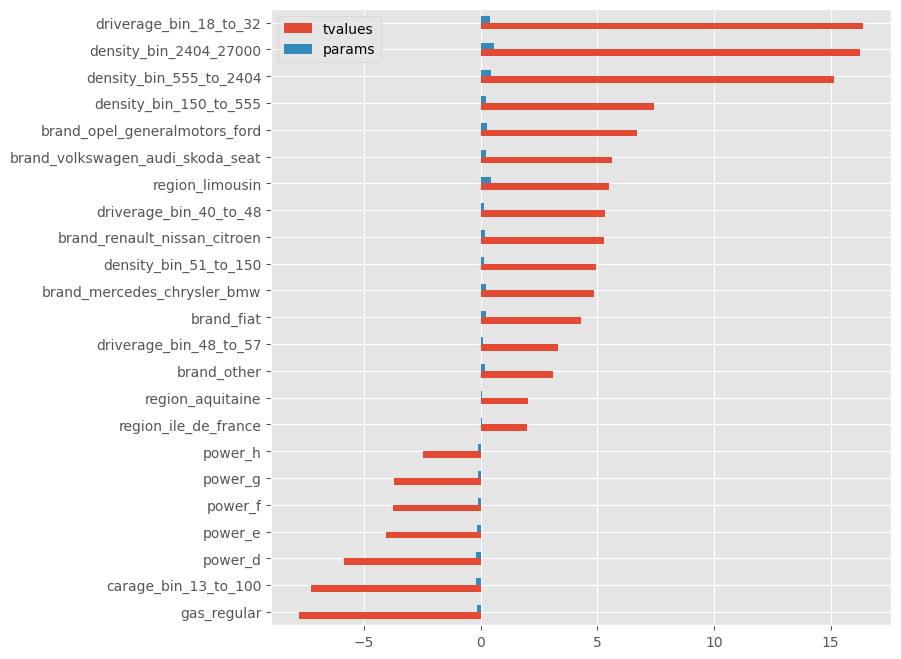

In [22]:
risk_factors_freq.sort_values(by='tvalues').plot.barh(figsize=(8,8))

In [23]:
results = defaultdict(lambda : defaultdict())

In [25]:
results['dev_poisson_train']['glm'] = mean_poisson_deviance(y_train, freq_glm.predict(x_train), sample_weight=exp_train)
results['dev_poisson_test']['glm'] = mean_poisson_deviance(y_test, freq_glm.predict(x_test), sample_weight=exp_test)
results['dev_poisson_train']['glm_backward'] = mean_poisson_deviance(y_train, freq_glm_backward.predict(x_train), sample_weight=exp_train)
results['dev_poisson_test']['glm_backward'] = mean_poisson_deviance(y_test, freq_glm_backward.predict(x_test), sample_weight=exp_test)

In [26]:
pd.DataFrame(results)

,dev_poisson_train,dev_poisson_test
glm,0.3073,0.3108
glm_backward,0.3073,0.3108


In [27]:
help(mean_poisson_deviance)

Help on function mean_poisson_deviance in module sklearn.metrics._regression:

mean_poisson_deviance(y_true, y_pred, *, sample_weight=None)
    Mean Poisson deviance regression loss.
    
    Poisson deviance is equivalent to the Tweedie deviance with
    the power parameter `power=1`.
    
    Read more in the :ref:`User Guide <mean_tweedie_deviance>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values. Requires y_true >= 0.
    
    y_pred : array-like of shape (n_samples,)
        Estimated target values. Requires y_pred > 0.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    Returns
    -------
    loss : float
        A non-negative floating point value (the best value is 0.0).
    
    Examples
    --------
    >>> from sklearn.metrics import mean_poisson_deviance
    >>> y_true = [2, 0, 1, 4]
    >>> y_pred = [0.5, 0.5, 2., 2.]
    >>> mean_poisson_dev

In [28]:
formula_freq
loss_function = mean_poisson_deviance
hyperparams_space = {'alpha': np.arange(0.001,1.01-0.001, 0.001),
                     'L1_wt': np.arange(0.001,1.01-0.001, 0.001),
                     'formula':[formula_freq],
                     'data':[None],
                     'exposure':[DATASET_TRAIN[params_blog_2.get(Constants2.EXPOSURE_NAME)]],
                     'family':[sm.families.Poisson(link=sm.families.links.log())]}
params_to_record = ['alpha', 'L1_wt']

In [29]:
cv_results = run_hyperopt(df=DATASET_TRAIN,
                              hyperparams_space=hyperparams_space,
                              model_fit_func=fit_regularized_model,
                              loss_function=mean_poisson_deviance,
                              params_to_record=params_to_record,
                              exposure_name = params_blog_2.get(Constants2.EXPOSURE_NAME),
                              target_name=params_blog_2.get(Constants2.NB_CLAIMS),
                              limit_time=1_800,
                              max_iter=100,
                              is_debug=True)

the number of the maximum iterations is 100
--------------------------------
1 iteration starting...
0.0 time elapsed...
--------------------------------
2 iteration starting...
58.743504762649536 time elapsed...
--------------------------------
3 iteration starting...
124.66848063468933 time elapsed...
--------------------------------
4 iteration starting...
180.69353699684143 time elapsed...
--------------------------------
5 iteration starting...
222.1435148715973 time elapsed...
--------------------------------
6 iteration starting...
265.4804928302765 time elapsed...
--------------------------------
7 iteration starting...
305.89747309684753 time elapsed...
--------------------------------
8 iteration starting...
327.3785984516144 time elapsed...
--------------------------------
9 iteration starting...
368.89630937576294 time elapsed...
--------------------------------
10 iteration starting...
390.3458275794983 time elapsed...
--------------------------------
11 iteration starting

In [30]:
cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss']
                      ).loc[:, ['cv_mean_loss', 'cv_std_loss'] + \
                            params_to_record].reset_index(drop=True)

,cv_mean_loss,cv_std_loss,alpha,L1_wt
0,0.3522,0.0007,0.0310,0.8450
1,0.4146,0.0006,0.0440,0.3070
2,0.4175,0.0006,0.0450,0.2970
3,0.5251,0.0005,0.0850,0.4680
4,0.5621,0.0006,0.0990,0.6640
5,0.6131,0.0005,0.1170,0.6120
6,0.6156,0.0006,0.1190,0.5090
7,0.7716,0.0006,0.1790,0.7230
8,0.7972,0.0008,0.2490,0.1750
9,0.9524,0.0010,0.4340,0.0970


In [45]:
best_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss']).head(1).reset_index()
best_results.transpose().rename(columns={0:'values'})

,values
index,27
losses,"[0.35149429276299826, 0.35340021879428474, 0.3513837433381484, 0.3523997889511992, 0.3521052223341917]"
cv_mean_loss,0.3522
cv_std_loss,0.0007
hyperparams,alpha:0.031-L1_wt:0.845
alpha,0.0310
L1_wt,0.8450


In [55]:
best_hyperparams = {'alpha':best_results.alpha.squeeze(), 'L1_wt':best_results.L1_wt.squeeze()}

In [57]:
glm_random_search = smf.glm(formula=formula_freq,
                   data=DATASET_TRAIN, 
                   exposure=DATASET_TRAIN[exposure_name],
                   family = sm.families.Poisson(link=sm.families.links.log())
                  ).fit_regularized(method="elastic_net", **best_hyperparams)

In [58]:
results['dev_poisson_train']['glm_random_search'] = mean_poisson_deviance(y_train, glm_random_search.predict(x_train), sample_weight=exp_train)
results['dev_poisson_test']['glm_random_search'] = mean_poisson_deviance(y_test, glm_random_search.predict(x_test), sample_weight=exp_test)

In [61]:
pd.DataFrame(results).sort_values(by='dev_poisson_test')

,dev_poisson_train,dev_poisson_test
glm_backward,0.3073,0.3108
glm,0.3073,0.3108
glm_random_search,0.3737,0.3754
